In [1]:
# -------------------------------------
# --- Go to correct starting folder ---
# -------------------------------------
# (when running jupyter lab in the browser, the notebook starts with CWD = folder where it is located, which breaks imports, ...)
import os
import pathlib

while not ((cwd := pathlib.Path(os.getcwd())) / "requirements.txt").exists():
    os.chdir(cwd.parent)  # go 1 folder up

In [2]:
# other imports
import numpy as np
from matplotlib import pyplot as plt

from core.tag import read_all_metadata
from core.tag.embeddings import compute_similarity
from notebooks.colors import CLR_BLACK, CLR_BLUE, CLR_GREY
from notebooks.helpers import enable_metadata, get_figures_folder, get_images_folder

/Users/bertpluymers/miniconda3/envs/image-search-llm/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


# Introduction

This notebook performs an analysis to check if the 2 embeddings extracted for each image are similar.  This should give us a feeling for reliability of the embeddings and might give a feeling of what the similarity scores might look like when performing actual queries.

In [3]:
# prep main loop
images_folder = get_images_folder()
emb_sizes = [128, 512, 2048]
similarities_by_emb_size: dict[int, list[float]] = dict()

# main loop
for emb_size in emb_sizes:
    # enable metadata for this size
    enable_metadata(emb_size)

    # read all metadata
    all_metadata = read_all_metadata(images_folder)
    similarities = [compute_similarity(metadata.embeddings.img, metadata.embeddings.txt) for metadata in all_metadata]

    print()
    print(f"Embeddings size: {emb_size}")
    print(f"   min self-similarity: {min(similarities):.4f}")
    print(f"   avg self-similarity: {np.mean(similarities):.4f}")
    print(f"   max self-similarity: {max(similarities):.4f}")

    similarities_by_emb_size[emb_size] = similarities


Embeddings size: 128
   min self-similarity: 0.5506
   avg self-similarity: 0.7781
   max self-similarity: 0.8990

Embeddings size: 512
   min self-similarity: 0.6079
   avg self-similarity: 0.7333
   max self-similarity: 0.8169

Embeddings size: 2048
   min self-similarity: 0.5910
   avg self-similarity: 0.7189
   max self-similarity: 0.8108


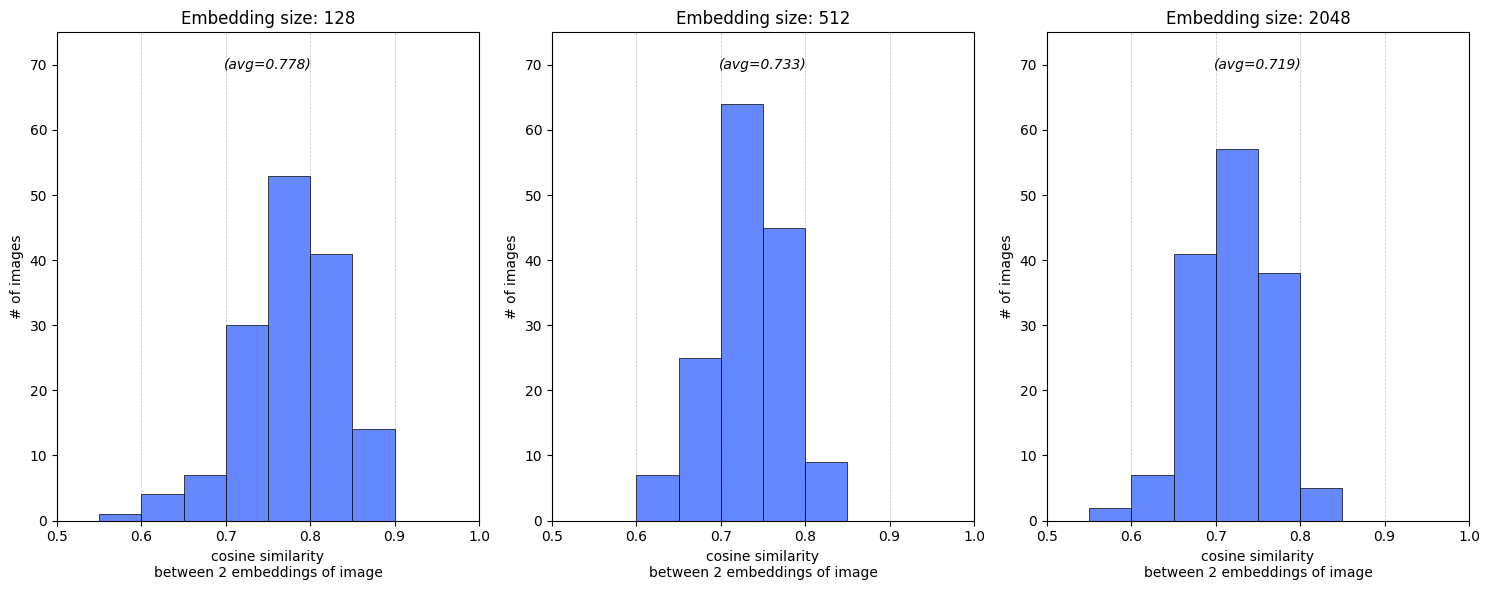

In [7]:
# plot results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

bins = np.arange(0.50, 1.00, 0.05)  # bins for histogram

for ax, (emb_size, similarities) in zip(axes, similarities_by_emb_size.items()):
    ax.hist(similarities, bins=bins, color=CLR_BLUE, edgecolor=CLR_BLACK, linewidth=0.5)

    ax.set_title(f"Embedding size: {emb_size}")
    ax.set_xlabel("cosine similarity\nbetween 2 embeddings of image")
    ax.set_ylabel("# of images")

    ax.set_xlim(0.5, 1.0)
    ax.set_ylim(0, 75)
    ax.grid(axis="x", ls="--", color=CLR_BLACK, lw=0.5, alpha=0.25)

    ax.text(0.75, 70, f"(avg={np.mean(similarities):.3f})", ha="center", va="center", fontstyle="italic")

fig.tight_layout()

In [5]:
# save figure
fig_file = get_figures_folder() / "self_similarity_histograms.png"
fig.savefig(fig_file, dpi=600)